# Flower Captioner Model finetune

In [ ]:
from transformers import VisionEncoderDecoderModel, GenerationConfig, default_data_collator
from transformers import ViTImageProcessor, GPT2TokenizerFast, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import Dataset, DatasetDict
from collections import Counter
from PIL import Image
from pathlib import Path
from textwrap import wrap
import numpy as np
import matplotlib.pyplot as plt
import evaluate
import torch
import json
import nltk
import os
import random


In [2]:
class FlowerDataset:
    def __init__(self, json_file, root_dir):
        self.root_dir = root_dir

        with open(json_file, 'r') as f:
            data = json.load(f)
            self.images = [item["ImagePath"] for item in data['annotations']]
            self.captions = [item["caption"] for item in data['annotations']]
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        caption = self.captions[idx]
        img_full_path = f"{self.root_dir}/{img_path}"
        return {
            'image_path': img_full_path,
            'caption': caption
        }
    def generator(self):
        for idx in range(len(self)):
            yield self[idx]

In [3]:
try:
    nltk.data.find("tokenizers/punkt")
    nltk.data.find("punkt_tab")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)
    nltk.download('punkt_tab', quiet=True)


In [ ]:
# Load pre-trained models and tokenizers
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = GPT2TokenizerFast.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [5]:
# GPT2 only has bos/eos tokens but not decoder_start/pad tokens
tokenizer.pad_token = tokenizer.eos_token

# update the model config
model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

model.generation_config = GenerationConfig(
    eos_token_id = tokenizer.eos_token_id,
    decoder_start_token_id = tokenizer.bos_token_id,
    pad_token_id = tokenizer.pad_token_id,
    max_new_tokens = 128
)


## Download Flower dataset if not found

In [6]:
data = Path("./data")
if(not data.resolve().exists()):
    print("downloading Flowers dataset")
    !git clone https://huggingface.co/datasets/cristianglezm/FlowerEvolver-Dataset "data"
else:
    print("flowers dataset found.")

flowers dataset found.


In [7]:
# Create the custom dataset
flower_dataset = FlowerDataset(
    json_file="./data/captions.json", 
    root_dir="./data"
)

# Convert the custom dataset to a Hugging Face Dataset
hf_dataset = Dataset.from_generator(flower_dataset.generator)

# Split the dataset into training and validation sets
dataset = hf_dataset.train_test_split(test_size=0.2)

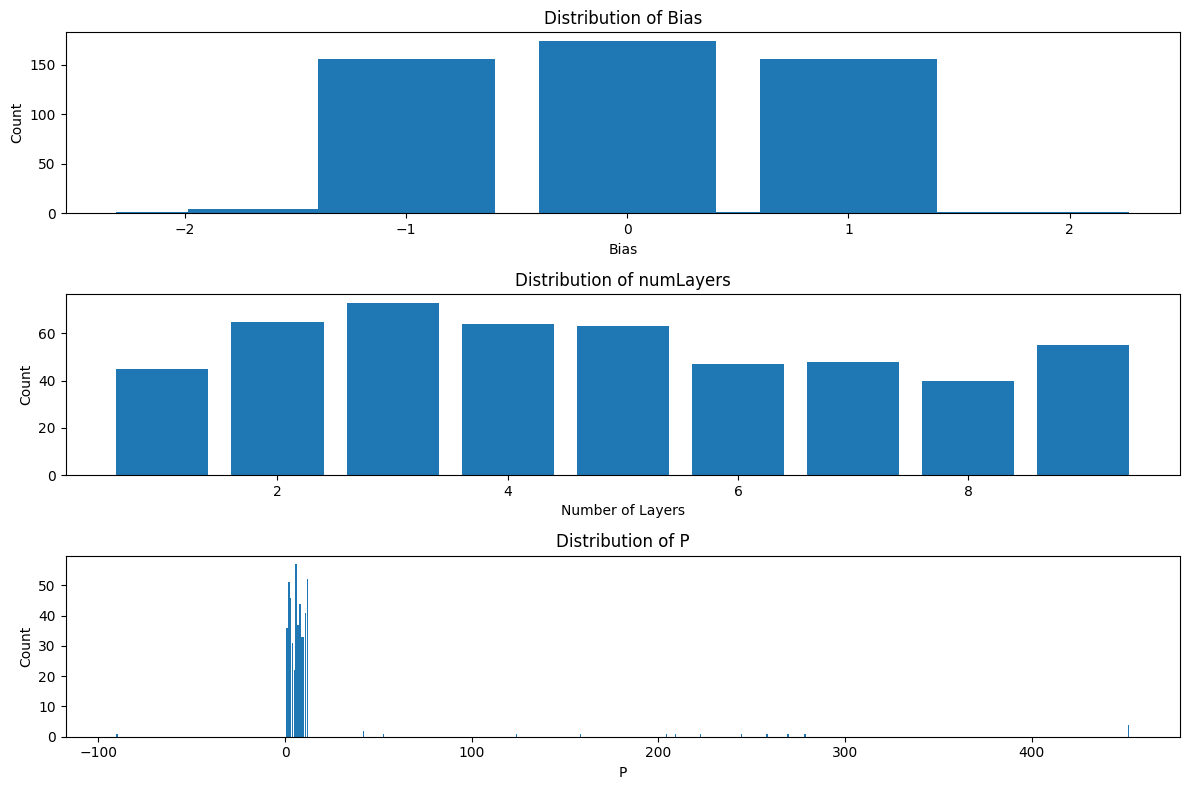

In [8]:
folder_path = './data/genomes'
bias_counter = Counter()
num_layers_counter = Counter()
P_counter = Counter()

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        with open(os.path.join(folder_path, file_name)) as f:
            data = json.load(f)
            petals = data.get('Flower', {}).get('petals', {})
            bias_counter[petals.get('bias')] += 1
            num_layers_counter[petals.get('numLayers')] += 1
            P_counter[petals.get('P')] += 1

plt.figure(figsize=(12, 8))

# Bias plot
plt.subplot(3, 1, 1)
plt.bar(bias_counter.keys(), bias_counter.values())
plt.title('Distribution of Bias')
plt.xlabel('Bias')
plt.ylabel('Count')

# numLayers plot
plt.subplot(3, 1, 2)
plt.bar(num_layers_counter.keys(), num_layers_counter.values())
plt.title('Distribution of numLayers')
plt.xlabel('Number of Layers')
plt.ylabel('Count')

# P plot
plt.subplot(3, 1, 3)
plt.bar(P_counter.keys(), P_counter.values())
plt.title('Distribution of P')
plt.xlabel('P')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


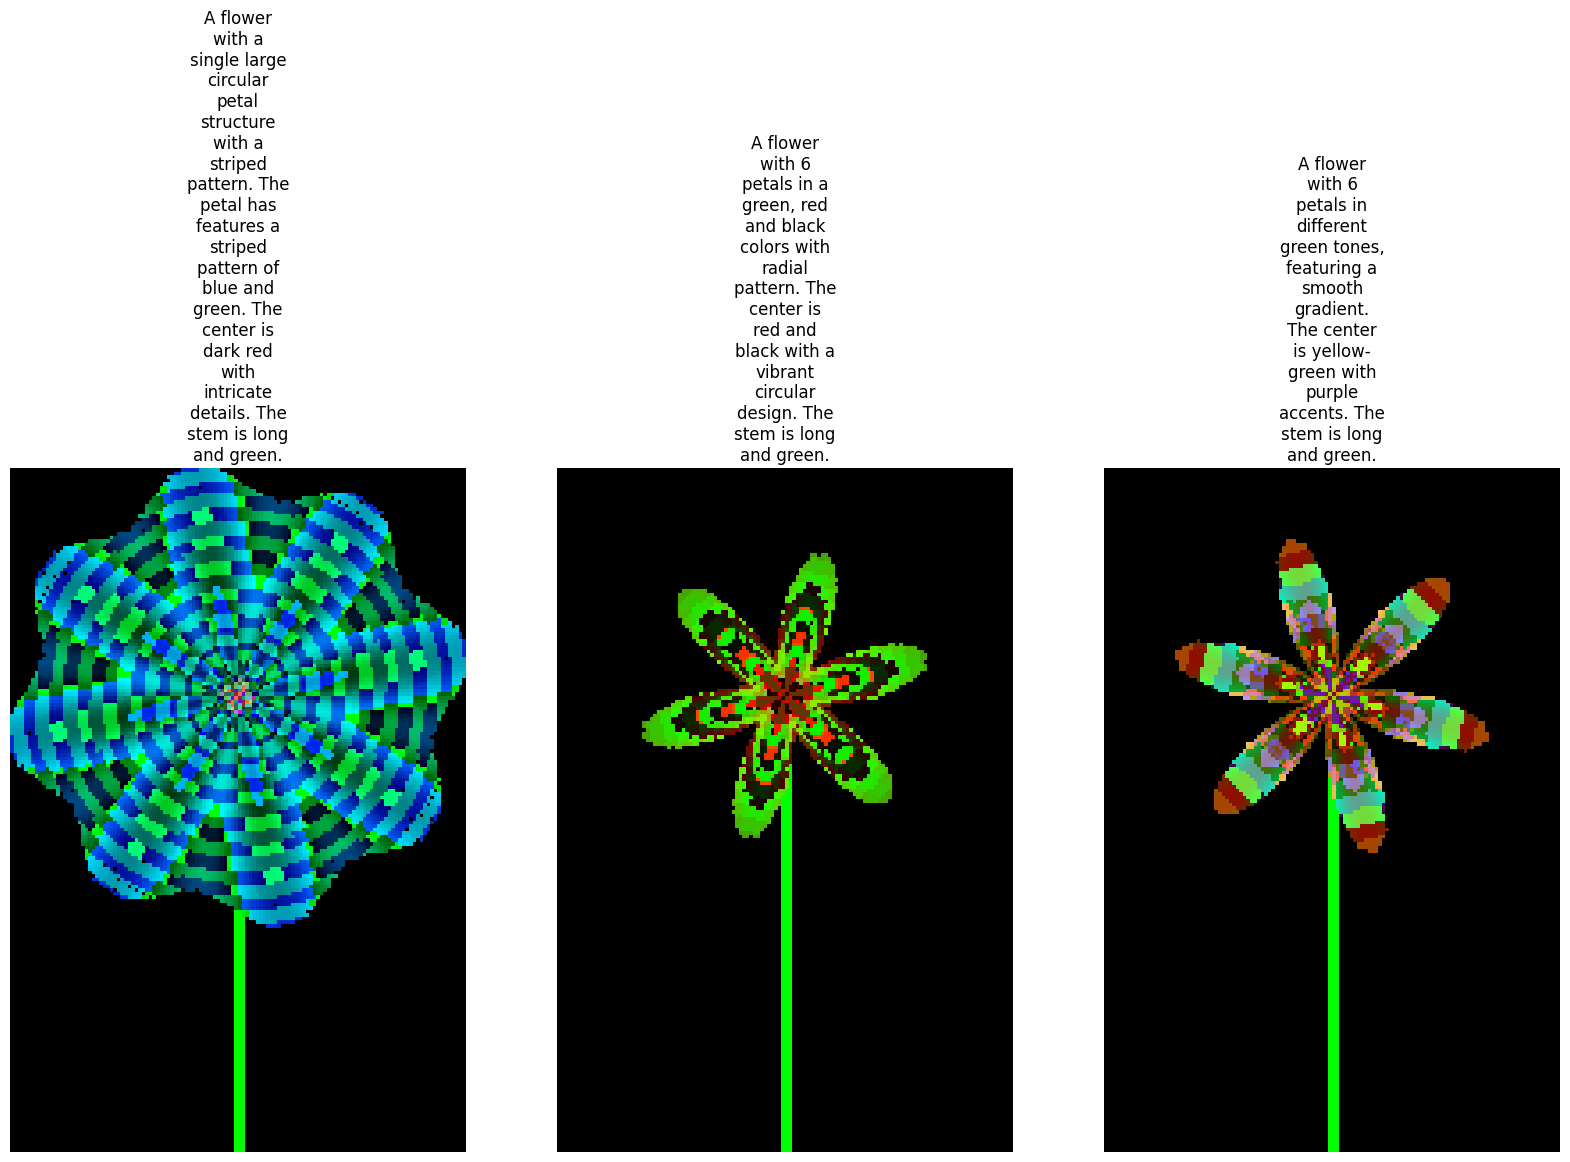

In [9]:
def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")

r = random.randrange(1, len(flower_dataset))
sample_flowers = [np.array(Image.open(flower_dataset[i]["image_path"]).convert("RGB")) for i in range(r, r+3)]
sample_captions = [flower_dataset[i]["caption"] for i in range(r, r+3)]
plot_images(sample_flowers, sample_captions)

In [10]:

# text preprocessing step
def tokenization_fn(captions, max_target_length):
    return tokenizer(captions, padding="max_length", max_length=max_target_length).input_ids
    
# image preprocessing step
def feature_extraction_fn(image_paths):
    images = [Image.open(image_file).convert("RGB") for image_file in image_paths]
    encoder_inputs = feature_extractor(images=images, return_tensors="np")
    return encoder_inputs.pixel_values

def preprocess_fn(dataset, max_target_length):
    image_paths = dataset['image_path']
    captions = dataset['caption']

    model_inputs = {}
    model_inputs['labels'] = tokenization_fn(captions, max_target_length)
    model_inputs['pixel_values'] = feature_extraction_fn(image_paths)

    return model_inputs

In [11]:

processed_dataset = dataset.map(
    function = preprocess_fn,
    batched = True,
    fn_kwargs = {"max_target_length": model.generation_config.max_new_tokens},
    remove_columns = dataset['train'].column_names
)


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [12]:
ignore_pad_token_for_loss = True
metric = evaluate.load("rouge")

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    preds = preds.astype(np.int64)
    labels = labels.astype(np.int64)
    if isinstance(preds, tuple):
        preds = preds[0]
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    result = metric.compute(predictions=decoded_preds,
                            references=decoded_labels,
                            use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result


In [13]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch", #eval_strategy="epoch",
    num_train_epochs=25,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    #logging_dir='./logs',
    logging_steps=10,
    output_dir="./FlowerCaptioner-training",
    report_to=None
)

In [ ]:
if(torch.cuda.is_available()):
    print("GPU found")
    torch.cuda.set_device(0)
else:
    print("GPU not found")

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset['train'],
    eval_dataset=processed_dataset['test'],
    data_collator=default_data_collator,
)
trainer.train()

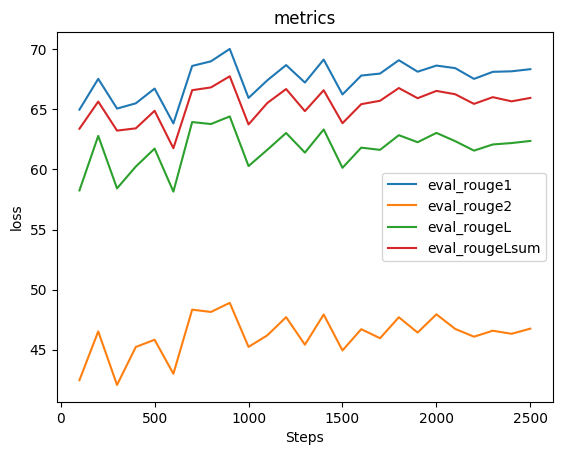

In [21]:
metrics = trainer.state.log_history

def showMetrics(metrics, ylabel, title, keys):
    for key in keys:    
        to_plot = [x[key] for x in metrics if key in x]
        steps = [x['step'] for x in metrics if key in x]
    
        plt.plot(steps, to_plot, label=key)
    plt.xlabel("Steps")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

showMetrics(metrics, 'loss', 'metrics', ['eval_rouge1', 'eval_rouge2', 'eval_rougeL', 'eval_rougeLsum'])


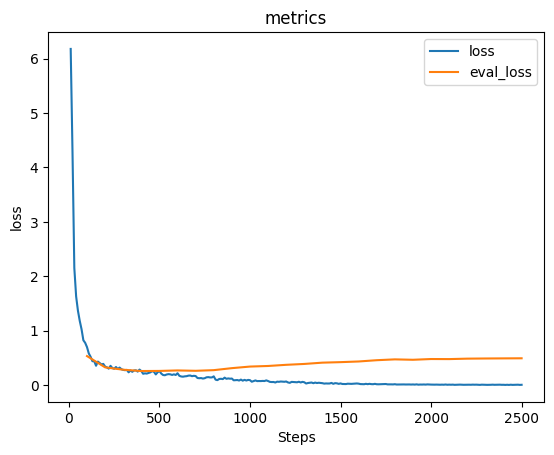

In [16]:
showMetrics(metrics, 'loss', 'metrics', ['loss', 'eval_loss'])

In [17]:
output_dir = "./models/FlowerCaptioner"
trainer.save_model(output_dir)
trainer.create_model_card(language="english", license="apache 2.0", 
                          tags=["art"], 
                          model_name="FlowerCaptioner", 
                          finetuned_from="nlpconnect/vit-gpt2-image-captioning",
                          tasks="image-to-text",
                          dataset_tags=["art"],
                          dataset="cristianglezm/FlowerEvolver-dataset")
tokenizer.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)


['./models/FlowerCaptioner\\preprocessor_config.json']

In [ ]:
from transformers import pipeline
output_dir = "./models/FlowerCaptioner"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
FlowerCaptioner = pipeline("image-to-text", model=output_dir, device=device)

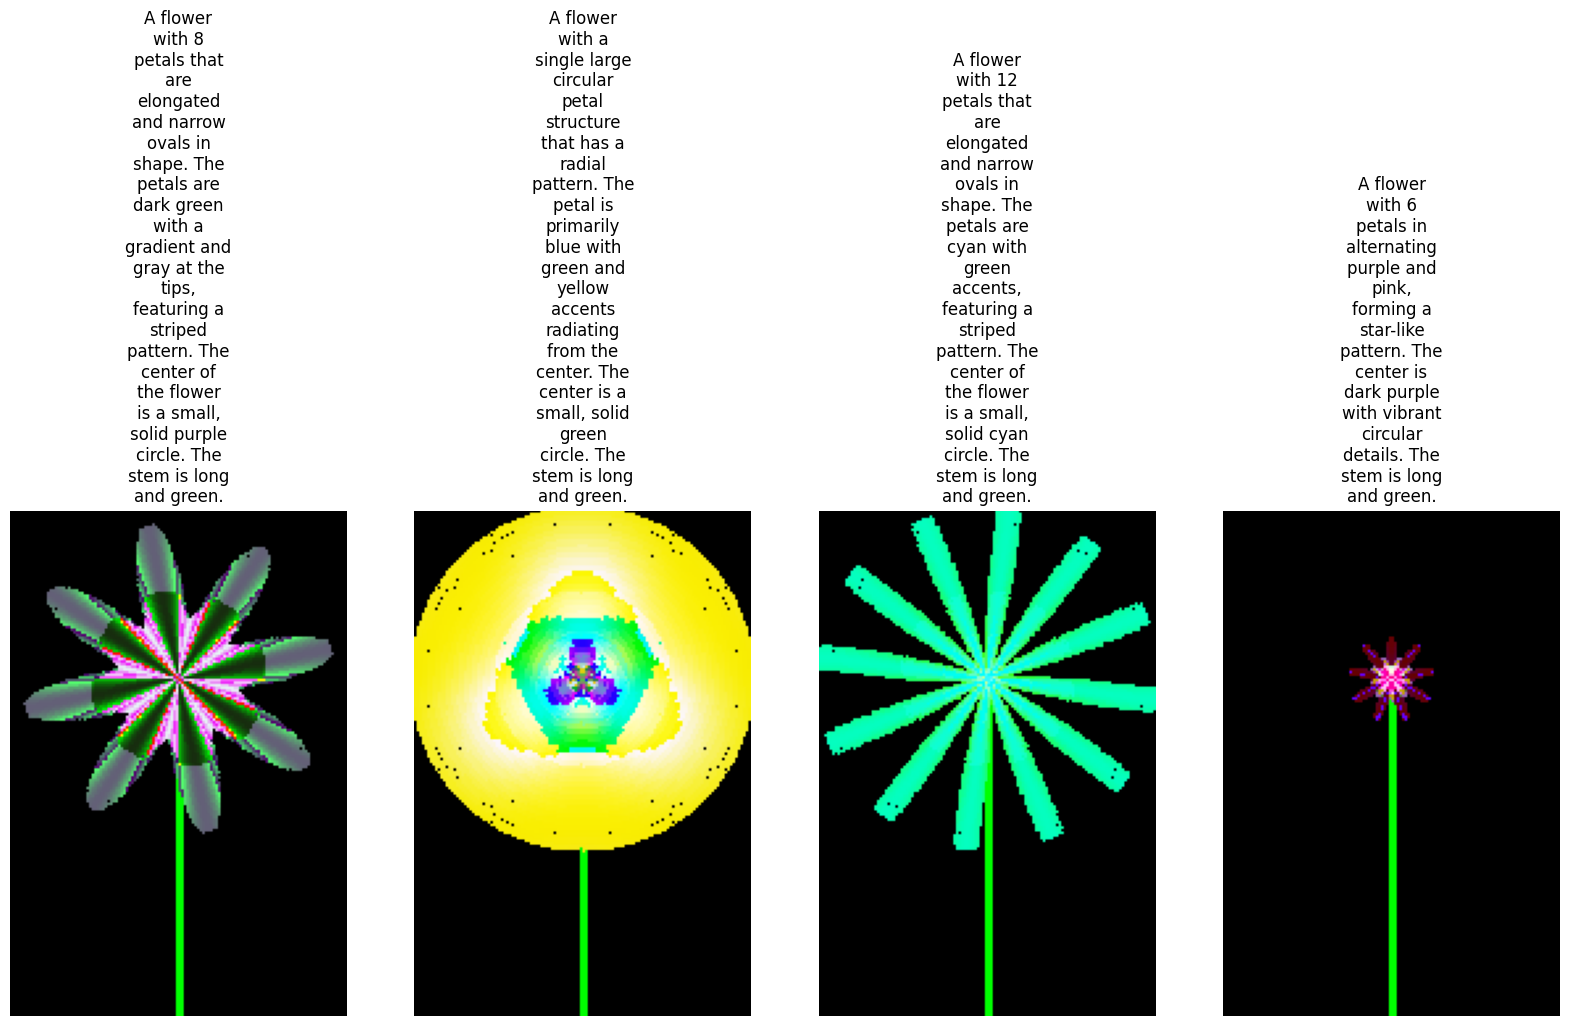

In [23]:
r = random.randrange(1, len(flower_dataset))
test_flowers = [flower_dataset[i]["image_path"] for i in range(r, r+4)]
test_captions = [captions[0]["generated_text"] for captions in FlowerCaptioner(test_flowers)]
test_images = [np.array(Image.open(flower_dataset[i]["image_path"]).convert("RGB")) for i in range(r, r+4)]
plot_images(test_images, test_captions)

## Convert to ONNX

In [ ]:
!python convert.py --quantize --model_id "./models/FlowerCaptioner" --task "image-to-text-with-past" --opset 18